# Visualize weights

In [1]:
import os
from nilearn.input_data import NiftiMasker
from nilearn import image
from nilearn.plotting import view_img, plot_stat_map
import nibabel as nb
import numpy as np
import pickle
import pandas as pd
from nilearn.reporting import get_clusters_table
from nilearn.image import threshold_img
from mni_to_atlas import AtlasBrowser
import atlasreader

pd.set_option("display.max_rows", 100)

atlas = AtlasBrowser("AAL3")

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [2]:
data_root = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2"
func_clean_dir = os.path.join(data_root, "derivatives", "func_clean")
fmriprep_dir = os.path.join(data_root, "derivatives", "fmriprep23")
stab_mask_dir = os.path.join(data_root, "derivatives", "mvpa_08_stability_bold", "stab_full_masks")  # for stability masks
weights_dir = os.path.join(data_root, "derivatives", "mvpa_08_stability_bold", "weights")  # for weights

# check if weights folder exist, if not create it
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

In [3]:
# Load the data from the file
with open("results_mvpa_08.pkl", "rb") as file:
    data_loaded = pickle.load(file)

# Access the variables
weights_list = data_loaded["weights_list"]

In [4]:
subject_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
class_names = ["JoyfulActivation", "Nostalgia", "Peacefulness", "Power", "Sadness", "Tenderness", "Tension", "Transcendence", "Wonder"]

# Main iteration

In [5]:
for idx, sub in enumerate(subject_list):
    print(sub)

    # load the stability mask
    stab_mask_data = np.load(os.path.join(stab_mask_dir, f"sub-{sub}_STAB.npy"))
    example_func = nb.load(os.path.join(func_clean_dir, f"sub-{sub}_ses-01_task-02a_run-1_cleaned.nii.gz"))

    stab_mask_img = nb.Nifti1Image(stab_mask_data, example_func.affine, example_func.header)

    thres = 0.1
    stab_mask_img_thres = image.threshold_img(stab_mask_img, threshold=thres, two_sided=False, copy_header=True)
    stab_mask_img_thres_bin = image.binarize_img(stab_mask_img_thres)

    # load the weights
    sub_weights = weights_list[idx]

    # apply abs to the weights
    sub_weights = np.abs(sub_weights)

    # transform the weights to nifti image
    masker = NiftiMasker(mask_img=stab_mask_img_thres_bin, standardize=False, detrend=False)
    masker.fit()

    sub_weights_image = masker.inverse_transform(sub_weights)

    # iterate through the classes
    for i, class_name in enumerate(class_names):
        print(class_name)

        # save the weights image
        nb.save(sub_weights_image.slicer[..., i], os.path.join(weights_dir, f"sub-{sub}_weights_{class_name}.nii.gz"))


01


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/image.py:1245: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img=threshold_img(


JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
02
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
03
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
04
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
05
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
06
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
07
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
08
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
09
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
10
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
11
JoyfulActivation
Nostalgia
Pea

# Load weight images and sum per condition

In [5]:
# get all the weight images for all conditions

for curr_cond in class_names:
    print(curr_cond)

    weight_images = []
    for sub in subject_list:
        weight_images.append(nb.load(os.path.join(weights_dir, f"sub-{sub}_weights_{curr_cond}.nii.gz")))
    weight_images = image.concat_imgs(weight_images)

    # sum the images
    sum_weight_images = image.math_img("np.sum(imgs, axis=3)", imgs=weight_images)

    # apply spatial smooting
    sum_weight_images_smooth = image.smooth_img(sum_weight_images, fwhm=4)

    # apply threshold
    sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)

    # save the thresholded image
    sum_weight_images_smooth_thr.to_filename(f"out_weights_img/sum_weight_images_smooth_thr_{curr_cond}.nii.gz")

    # get atlas data
    atlasreader.create_output(
        sum_weight_images_smooth_thr,
        cluster_extent=1,
        voxel_thresh=0,
        outdir="out_atlasreader",
        atlas=[
            "aal",
            "destrieux",
            "harvard_oxford",
            "juelich",
            "talairach_ba",
        ],  # all options: aal , aicha, desikan_killiany, destrieux, harvard_oxford, juelich , marsatlas, neuromorphometrics, talairach_ba, talairach_gyrus
        prob_thresh=25,  # minimum 25% probability for the label to be included
        export_figs=False,  # custom field
        outname=f"atlas_{curr_cond}",  # custom field
    )


JoyfulActivation


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Nostalgia


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Peacefulness


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Power


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Sadness


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Tenderness


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Tension


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Transcendence


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Wonder


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

# Visualize per condition

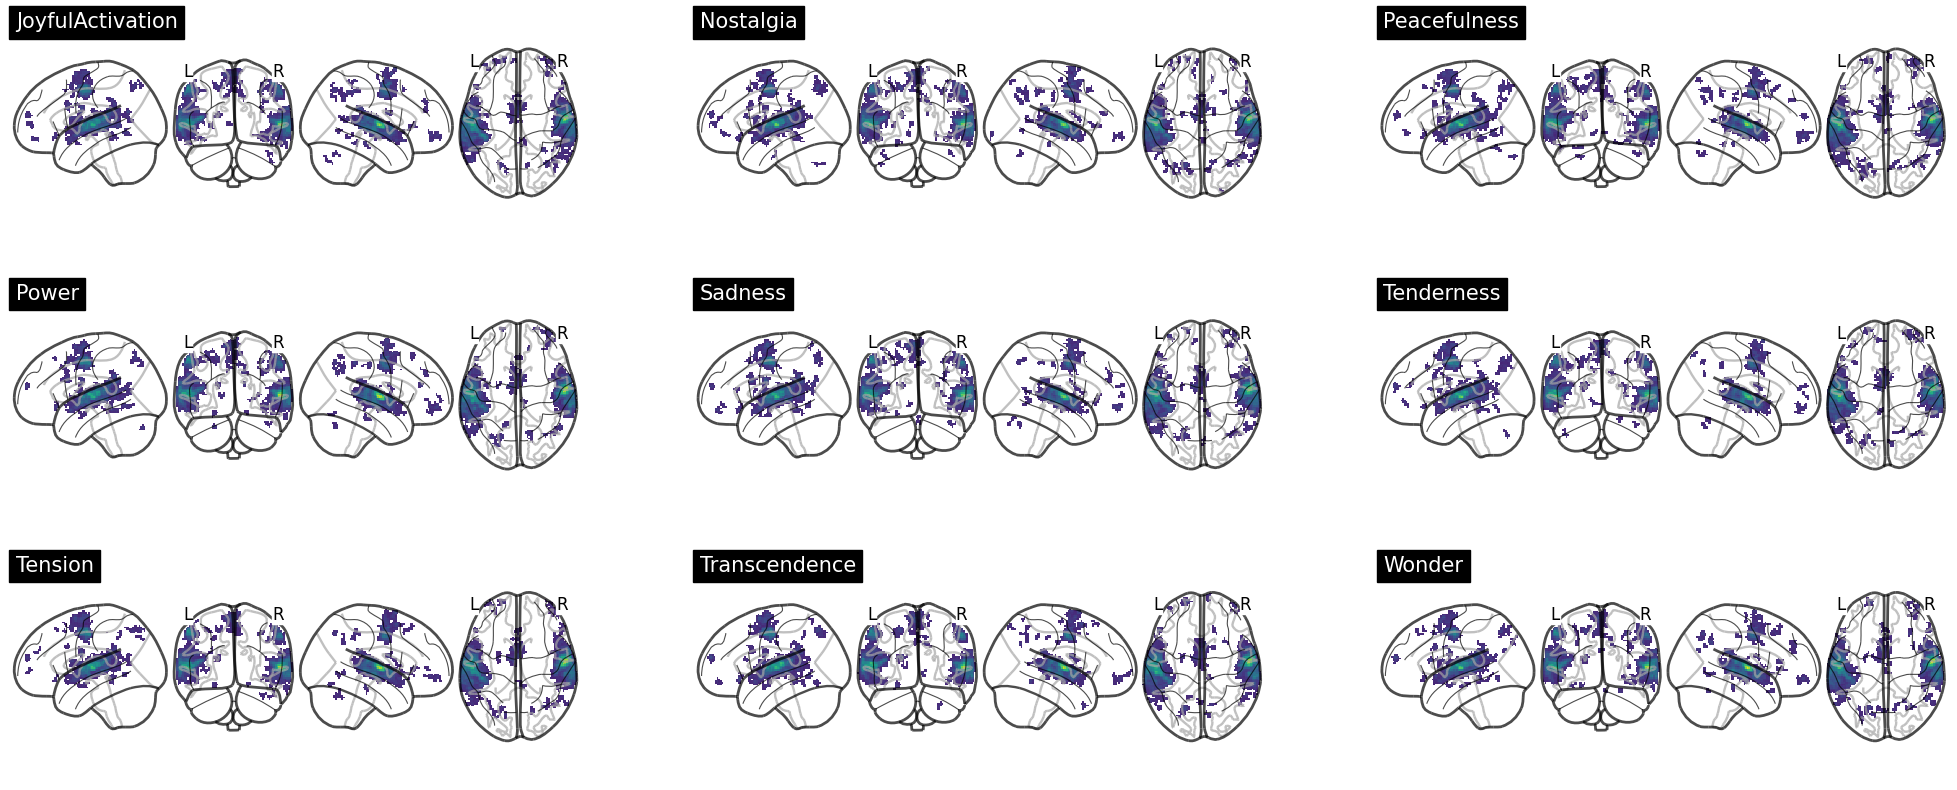

In [6]:
# let's a subplot of the nine conditions
# in each subplot, a plot_glass_brain of the thresholded image

import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain

fig, axs = plt.subplots(3, 3, figsize=(25, 10))

for i, curr_cond in enumerate(class_names):
    # apply threshold
    sum_weight_images_smooth_thr = nb.load(f"out_weights_img/sum_weight_images_smooth_thr_{curr_cond}.nii.gz")

    # plot the glass brain
    plot_glass_brain(
        sum_weight_images_smooth_thr,
        title=curr_cond,
        display_mode="lyrz",
        cmap="viridis",
        axes=axs.flatten()[i],
        vmax=0.05,
        resampling_interpolation="nearest",
    )

# Sum everything

/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_10548/2398723823.py:11: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_all_thr = threshold_img(sum_weight_images_all, threshold="99%", cluster_threshold=20)


Text(0, 0.5, 'Predictive Power (Sum of weights)')

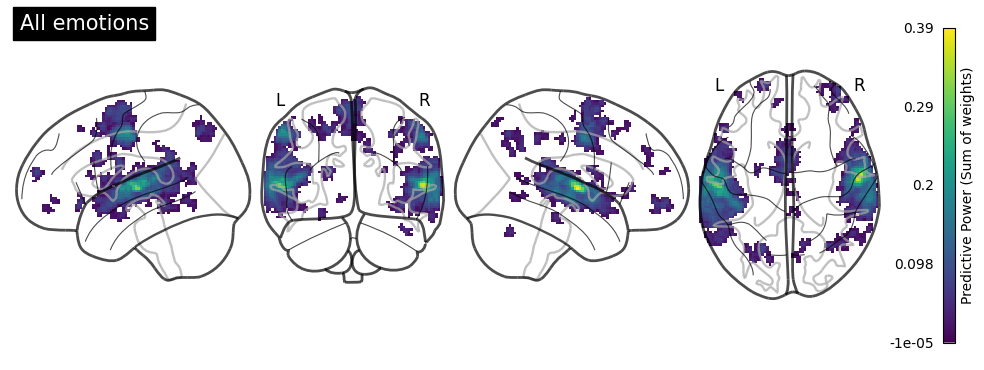

In [7]:
# let's sum the images of all conditions
weight_images = []
for curr_cond in class_names:
    weight_images.append(nb.load(f"out_weights_img/sum_weight_images_smooth_thr_{curr_cond}.nii.gz"))
weight_images = image.concat_imgs(weight_images)

# sum the images
sum_weight_images_all = image.math_img("np.sum(imgs, axis=3)", imgs=weight_images)

# threshold the sum image
sum_weight_images_all_thr = threshold_img(sum_weight_images_all, threshold="99%", cluster_threshold=20)

# plot
P = plot_glass_brain(
    sum_weight_images_all_thr,
    title="All emotions",
    display_mode="lyrz",
    cmap="viridis",
    # vmax=0.05,
    resampling_interpolation="nearest",
    colorbar=True,
)

# edit colorbar label
P._cbar.ax.set_ylabel("Predictive Power (Sum of weights)")

In [8]:
# get atlas data
atlasreader.create_output(
    sum_weight_images_all_thr,
    cluster_extent=1,
    voxel_thresh=0,
    outdir="out_atlasreader",
    atlas=[
        "aal",
        "destrieux",
        "harvard_oxford",
        "juelich",
        "talairach_ba",
    ],  # all options: aal , aicha, desikan_killiany, destrieux, harvard_oxford, juelich , marsatlas, neuromorphometrics, talairach_ba, talairach_gyrus
    prob_thresh=25,  # minimum 25% probability for the label to be included
    export_figs=False,  # custom field
    outname="atlas_ALL",  # custom field
)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)


In [9]:
pd.read_csv("out_atlasreader/atlas_ALL_clusters.csv")

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,destrieux,harvard_oxford,juelich,talairach_ba
0,1.0,-56.5,-16.5,3.5,0.065944,38096.0,28.85% Temporal_Sup_L,47.40% Unknown,NaN,35.41% no_label,59.74% Background
1,2.0,57.5,-10.5,3.5,0.073539,24456.0,53.03% Temporal_Sup_R,45.34% Unknown,NaN,39.12% no_label,58.46% Background
2,3.0,-10.5,-6.5,65.5,0.039414,6160.0,67.92% Supp_Motor_Area_L; 26.49% Supp_Motor_Ar...,38.44% Unknown; 35.32% ctx_lh_G_front_sup,44.29% Left_Juxtapositional_Lobule_Cortex_(for...,68.83% GM_Premotor_cortex_BA6_L; 28.05% GM_Pre...,64.55% Background; 32.08% Brodmann_area_6
3,4.0,55.5,-4.5,43.5,0.055509,4312.0,66.42% Precentral_R; 26.16% Frontal_Mid_2_R,42.30% Unknown; 30.06% ctx_rh_G_precentral,76.25% Right_Precentral_Gyrus,66.05% GM_Premotor_cortex_BA6_R,67.16% Background
4,5.0,-18.5,-66.5,47.5,0.029299,1648.0,90.78% Parietal_Sup_L,50.97% Unknown,100.00% Left_Lateral_Occipital_Cortex_superior...,40.78% GM_Superior_parietal_lobule_7A_L; 30.58...,63.11% Background; 36.89% Brodmann_area_7
5,6.0,39.5,59.5,-8.5,0.030518,1256.0,64.33% Frontal_Mid_2_R,49.68% ctx_rh_G_orbital; 29.94% Unknown,100.00% Right_Frontal_Pole,100.00% no_label,63.06% Background; 30.57% Brodmann_area_10
6,7.0,33.5,-66.5,47.5,0.027179,1176.0,63.27% Angular_R; 34.69% Parietal_Inf_R,44.90% Right-Cerebral-White-Matter; 30.61% ctx...,61.22% Right_Lateral_Occipital_Cortex_superior...,63.95% GM_Inferior_parietal_lobule_Pga_R,56.46% Background
7,8.0,-48.5,13.5,27.5,0.030677,744.0,52.69% Frontal_Inf_Tri_L; 38.71% Frontal_Inf_O...,56.99% Unknown; 36.56% ctx_lh_G_front_inf-Oper...,66.67% Left_Inferior_Frontal_Gyrus_pars_opercu...,92.47% GM_Broca's_area_BA44_L,61.29% Background; 38.71% Brodmann_area_9
8,9.0,-18.5,63.5,17.5,0.033143,664.0,93.98% Frontal_Sup_2_L,40.96% ctx_lh_G_front_middle; 27.71% Unknown,100.00% Left_Frontal_Pole,100.00% no_label,65.06% Brodmann_area_10; 34.94% Background
9,10.0,-64.5,-56.5,-6.5,0.023844,568.0,47.89% Temporal_Mid_L; 43.66% Temporal_Inf_L,38.03% Unknown; 26.76% ctx_lh_G_temporal_middl...,81.69% Left_Middle_Temporal_Gyrus_temporooccip...,100.00% no_label,81.69% Background
